In [1]:
# Set seeds for reproducibility
import random
random.seed(0)

import numpy as np
np.random.seed(0)

import tensorflow as tf
tf.random.set_seed(0)

In [2]:
import os
import json
from zipfile import ZipFile
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.applications import Xception

In [3]:
base_dir = 'D:/testproject/plantvillage dataset/color'
#base_dir = 'D:/testproject/dataset/PlantDiseasesDataset'

In [4]:
# Image Parameters
img_size = 299  # Xception's default input size
batch_size = 32

In [8]:
# Image Data Generators
data_gen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2  # Use 20% of train data for validation
)


In [9]:
# Train Generator
train_generator = data_gen.flow_from_directory(
    base_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    subset='training',
    class_mode='categorical'
)

Found 21579 images belonging to 16 classes.


" train_generator = train_data_gen.flow_from_directory(\n    train_data_dir,\n    target_size=(img_size, img_size),\n    batch_size=batch_size,\n    class_mode='categorical',\n    shuffle=True,\n    subset='training'\n) "

In [10]:
# Validation Generator
validation_generator = data_gen.flow_from_directory(
    base_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    subset='validation',
    class_mode='categorical'
)

Found 5388 images belonging to 16 classes.


" validation_generator = train_data_gen.flow_from_directory(\n    valid_data_dir,\n    target_size=(img_size, img_size),\n    batch_size=batch_size,\n    class_mode='categorical',\n    shuffle=False\n) "

In [11]:
# Load pre-trained Xception model
base_model = Xception(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

In [12]:
# Freeze convolutional layers
for layer in base_model.layers:
    layer.trainable = False

In [13]:
# Add custom classification layers on top of Xception
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(train_generator.num_classes, activation='softmax')
])

In [14]:
# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [15]:
# Model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 10, 10, 2048)      20861480  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 16)                4112      
                                                                 
Total params: 21390136 (81.60 MB)
Trainable params: 528656 (2.02 MB)
Non-trainable params: 20861480 (79.58 MB)
___________

In [16]:
# Training the Model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,  # Number of steps per epoch
    epochs=7,  # Number of epochs
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size  # Validation steps
)

Epoch 1/7


674/674 [==============================] - 2774s 4s/step - loss: 0.6861 - accuracy: 0.7882 - val_loss: 0.3634 - val_accuracy: 0.8772
Epoch 2/7
674/674 [==============================] - 2696s 4s/step - loss: 0.3711 - accuracy: 0.8798 - val_loss: 0.2639 - val_accuracy: 0.9137
Epoch 3/7
674/674 [==============================] - 2719s 4s/step - loss: 0.2973 - accuracy: 0.9005 - val_loss: 0.2355 - val_accuracy: 0.9232
Epoch 4/7
674/674 [==============================] - 2712s 4s/step - loss: 0.2485 - accuracy: 0.9157 - val_loss: 0.2203 - val_accuracy: 0.9275
Epoch 5/7
674/674 [==============================] - 2716s 4s/step - loss: 0.2218 - accuracy: 0.9251 - val_loss: 0.2100 - val_accuracy: 0.9327
Epoch 6/7
674/674 [==============================] - 2717s 4s/step - loss: 0.1984 - accuracy: 0.9321 - val_loss: 0.2004 - val_accuracy: 0.9334
Epoch 7/7
674/674 [==============================] - 2701s 4s/step - loss: 0.1847 - accuracy: 0.9363 - val_loss: 0.1885 - val_accuracy: 0.93

In [17]:
# Model Evaluation
print("Evaluating model...")
val_loss, val_accuracy = model.evaluate(validation_generator, steps=validation_generator.samples // batch_size)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

Evaluating model...
168/168 [==============================] - 541s 3s/step - loss: 0.1885 - accuracy: 0.9321
Validation Accuracy: 93.21%


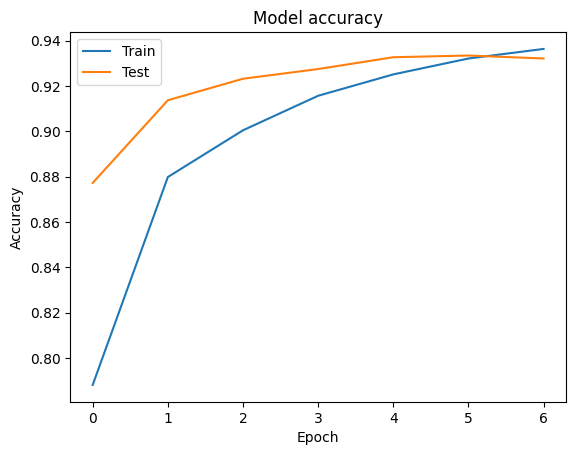

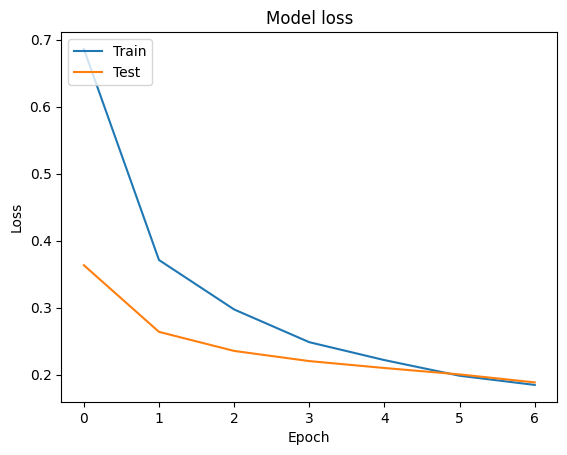

In [18]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [47]:
# Function to Load and Preprocess the Image using Pillow
def load_and_preprocess_image(image_path, target_size=(299, 299)):
    # Load the image
    img = Image.open(image_path)
    # Resize the image
    img = img.resize(target_size)
    # Convert the image to a numpy array
    img_array = np.array(img)
    # Add batch dimension
    img_array = np.expand_dims(img_array, axis=0)
    # Scale the image values to [0, 1]
    img_array = img_array.astype('float32') / 255.
    return img_array

# Function to Predict the Class of an Image
def predict_image_class(model, image_path, class_indices):
    preprocessed_img = load_and_preprocess_image(image_path)
    predictions = model.predict(preprocessed_img)
    predicted_class_index = np.argmax(predictions, axis=1)[0]
    predicted_class_name = class_indices[predicted_class_index]
    return predicted_class_name

In [36]:
# Create a mapping from class indices to class names
class_indices = {v: k for k, v in train_generator.class_indices.items()}

In [37]:
class_indices

{0: 'Potato___Early_blight',
 1: 'Potato___Late_blight',
 2: 'Potato___healthy',
 3: 'Soybean___healthy',
 4: 'Strawberry___Leaf_scorch',
 5: 'Strawberry___healthy',
 6: 'Tomato___Bacterial_spot',
 7: 'Tomato___Early_blight',
 8: 'Tomato___Late_blight',
 9: 'Tomato___Leaf_Mold',
 10: 'Tomato___Septoria_leaf_spot',
 11: 'Tomato___Spider_mites Two-spotted_spider_mite',
 12: 'Tomato___Target_Spot',
 13: 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 14: 'Tomato___Tomato_mosaic_virus',
 15: 'Tomato___healthy'}

In [38]:
# saving the class names as json file
json.dump(class_indices, open('class_indices.json', 'w'))

In [51]:
# Example Usage
image_path = 'D:/testproject/plantvillage dataset/color/Tomato___Tomato_mosaic_virus/0a91f50b-1263-4b2c-a8c1-f2a6025b82f3___PSU_CG 2136.JPG'
#image_path = '/content/test_blueberry_healthy.jpg'
#image_path = '/content/test_potato_early_blight.jpg'
predicted_class_name = predict_image_class(model, image_path, class_indices)

# Output the result
print("Predicted Class Name:", predicted_class_name)

1/1 [==============================] - 0s 134ms/step
Predicted Class Name: Tomato___Tomato_mosaic_virus


In [34]:
model.save('plant_disease_prediction_model[xception].h5')

c:\Users\Nabu\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
